In [0]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten, Reshape, LSTM, Conv2DTranspose
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
import numpy as np
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image, ImageDraw
import os
from os.path import join
from IPython.display import clear_output
gpu = tf.config.experimental.list_physical_devices('GPU')[0]
tf.config.experimental_run_functions_eagerly(True)

In [2]:
(train_images, train_number), (test_images, test_number) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
train_images = (train_images.reshape(-1, 28, 28, 1) / 255. > 0.5).astype('float32')

In [0]:
latent_dim = 10
hldim = int((28 * 28 * latent_dim) ** 0.5)
hldim = 512

inp = Input((28, 28, 1))
# x = Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu')(inp)
# x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu')(x)
# x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.Dense(latent_dim + latent_dim)(x)
x = tf.keras.layers.Flatten()(inp)
x = Dense((hldim), 'relu')(x)
x = Dense(latent_dim * 2)(x)
encoder_model = Model(inp, x)

inp = Input(latent_dim)
# x = Dense(7*7*32, 'relu')(inp)
# x = Reshape((7, 7, 32))(x)
# x = Conv2DTranspose(filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation='relu')(x)
# x = Conv2DTranspose(filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation='relu')(x)
# x = Conv2DTranspose(filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation='sigmoid')(x)
x = Dense((hldim), 'relu')(inp)
x = Dense(28 * 28, 'sigmoid')(x)
x = Reshape((28, 28, 1))(x)
decoder_model = Model(inp, x)

opt = tf.keras.optimizers.Adam()

In [0]:
@tf.function
def train_on_batch(batch, optimizer):
    with tf.GradientTape() as tape:
        tv = decoder_model.trainable_variables + encoder_model.trainable_variables
        tape.watch(tv)
        pred = encoder_model(batch)
        mid, logsigm = tf.split(pred, num_or_size_splits=2, axis=1)
        eps = tf.random.normal(shape=mid.shape)
        pred = eps * tf.exp(logsigm * .5) * 0.1 + mid
        pred = decoder_model(pred)
        L0 = tf.reduce_mean(tf.keras.losses.binary_crossentropy(batch, pred))
        L1 = 1 * tf.keras.backend.mean((tf.exp(logsigm) - 1. - logsigm) * 0.0005 + tf.square(mid) * 0.002)
        # print(tf.shape(L0))
        # print(tf.shape(L1))
        L = L0 + L1
    grad = tape.gradient(L, tv)
    optimizer.apply_gradients(zip(grad, tv))
    return L

#train_on_batch(train_images[:2], opt)

In [0]:
train_final = train_images[:2 ** 14]

In [ ]:
colors =  ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
losses = []
min_loss = 10 ** 100
cnt = 0
for i in range(1000000):
  err = train_on_batch(train_final, opt).numpy()
  losses.append(err)
  if i % 100 == 0:
    min_loss = err
    img = decoder_model.predict(encoder_model.predict(train_images[2:3])[0,:latent_dim].reshape(1, latent_dim)).reshape(28, 28)
    clear_output(wait=True)
    test = encoder_model.predict(train_images[:10000])
    plt.imshow(img)
    plt.show()
    #axes = plt.gca()
    #axes.set_xlim([-0.0001,0.0001])
    #axes.set_ylim([-0.00005,0.00005])
    plt.scatter(test[:,0], test[:,1], c = [colors[train_number[_]] for _ in range(10000)])
    plt.show()
    plt.plot(np.log(losses)[:])
    plt.show()
    print(err)

In [0]:
five, zero = encoder_model.predict(train_images[0:2])[:,:latent_dim]
#print((five * 3 + zero * 7).shape)
print(five, zero)
for i in range(0, 11):
  v = (five * i / 10. + zero * (10 - i) / 10.).reshape(1, latent_dim)
  img = decoder_model.predict(v).reshape(28, 28)
  plt.imshow(img)
  plt.show()

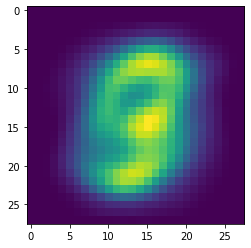

In [0]:
img = decoder_model.predict(encoder_model.predict(train_images[1:2])[0,:latent_dim].reshape(1, latent_dim)).reshape(28, 28)
plt.imshow(img)

In [0]:
!pip install -q imageio

In [0]:
from IPython import display

In [0]:
def train_on_batches(x, opt):
  for i in x:
    #print(i.shape)
    train_on_batch(i, opt)

In [0]:
train_images.shape

(60000, 28, 28, 1)

In [0]:
time_data = []
batches = train_images[:2 ** 14]
import time
for i in range(10, 15):
  print(i)
  tmp = batches.reshape(-1, 2 ** i, 28, 28, 1)
  begin = time.time()
  train_on_batches(tmp, opt)
  end = time.time()
  time_data.append([i, end-begin])

10
11
12
13
14


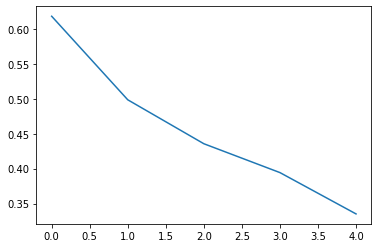

In [0]:
data2 = [time_data[i][1] for i in range(len(time_data))]
plt.plot(data2)

In [13]:
from tqdm.autonotebook import tqdm


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  """Entry point for launching an IPython kernel.


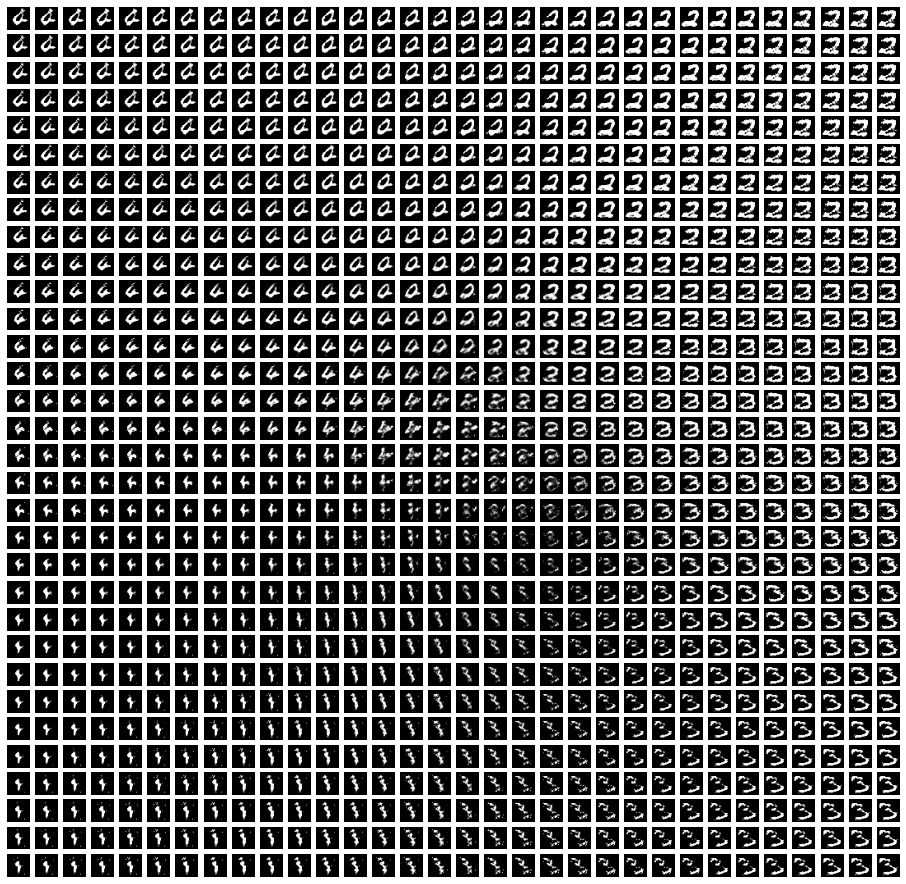

In [27]:
N = 32
fig = plt.figure(figsize=(N / 2,N / 2))
for i in tqdm(range(N * N)):
  plt.subplot(N, N, i+1)
  x = (i % N - N // 2) / N * 2 * 5
  y = (i // N - N // 2) / N * 2 * 5
  plt.imshow(decoder_model.predict(np.array([x, y, 0, 0, 0, 0, 0, 0, 0, 0]).reshape(1, 10)).reshape(28, 28), cmap='gray')
  plt.axis('off')

